# Baseline Fruit Ripeness Classifier

Quick-start notebook tuned for Google Colab GPU usage.

1. Install dependencies.
2. Upload your `kaggle.json` when prompted.
3. Download and prepare the dataset (handled below).
4. Run the training and evaluation cells.

You can also run this locally; skip the Kaggle upload cell if your credentials are already configured.

## 1. Install Dependencies
Run this cell once per Colab session to install PyTorch, Kaggle, and analysis libraries.


In [ ]:
%%capture
!pip install -q kagglehub torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q numpy pandas scikit-learn matplotlib seaborn tqdm

## 2. Import Libraries and Configure the Runtime
Imports the packages needed for data handling, modelling, and plotting, then reports the active device.


In [ ]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Torch version: {torch.__version__}")

Using device: cuda
Torch version: 2.8.0+cu126


## 3. Configure Kaggle Credentials
Upload your Kaggle API token so the dataset can be downloaded automatically. The next cell also fixes the token file permissions required by Kaggle.


In [ ]:
try:
    from google.colab import files  # type: ignore
    IS_COLAB = True
except ImportError:
    files = None
    IS_COLAB = False

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(parents=True, exist_ok=True)

kaggle_json = kaggle_dir / "kaggle.json"
if not kaggle_json.exists():
    if files is None:
        raise FileNotFoundError(
            "kaggle.json not found. Upload it in Colab or place it in ~/.kaggle/"
        )
    print("Upload your kaggle.json file (Account > Create New API Token).")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No files uploaded.")
    if "kaggle.json" in uploaded:
        data = uploaded["kaggle.json"]
    else:
        filename, data = next(iter(uploaded.items()))
        print(f"Received '{filename}'. Renaming to 'kaggle.json'.")
    kaggle_json.write_bytes(data)
    print("kaggle.json uploaded.")
else:
    print("kaggle.json already present; skipping upload.")


Upload your kaggle.json file (Account > Create New API Token).


Saving Kaggle Settings.json to Kaggle Settings.json
Received 'Kaggle Settings.json'. Renaming to 'kaggle.json'.
kaggle.json uploaded.


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

## 4. Download and Prepare the Dataset
Downloads the Kaggle dataset with `kagglehub`, extracts archives, and locates the train/test directories.


In [ ]:
import shutil
import zipfile

import kagglehub

DATASET_SLUG = "leftin/fruit-ripeness-unripe-ripe-and-rotten"
TARGET_DIR = Path("data/fruit_ripeness_dataset")
FORCE_DOWNLOAD = False  # Set to True to refresh the dataset


def iter_files(path: Path):
    return [p for p in path.rglob('*') if p.is_file()]


def copy_contents(src: Path, dst: Path) -> None:
    files = iter_files(src)
    if not files:
        return
    for file_path in tqdm(files, desc="Copying dataset files", unit="file"):
        relative = file_path.relative_to(src)
        target = dst / relative
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file_path, target)


def extract_archives(path: Path) -> None:
    zip_files = list(path.rglob("*.zip"))
    for zip_path in tqdm(zip_files, desc="Extracting archives", unit="zip"):
        extract_dir = zip_path.with_suffix("")
        extract_dir.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(zip_path, "r") as zf:
            members = zf.namelist()
            for member in tqdm(members, desc=f"Extracting {zip_path.name}", leave=False, unit="file"):
                zf.extract(member, extract_dir)
        zip_path.unlink()


def find_split_dir(root: Path, name: str):
    candidates = sorted(
        [p for p in root.rglob(name) if p.is_dir()],
        key=lambda p: len(p.parts),
    )
    for candidate in candidates:
        if any(candidate.glob("*/*")):
            return candidate
    return None


if TARGET_DIR.exists() and not FORCE_DOWNLOAD:
    print(f"Dataset already present at {TARGET_DIR.resolve()}\nSet FORCE_DOWNLOAD=True to re-download.")
else:
    if TARGET_DIR.exists() and FORCE_DOWNLOAD:
        shutil.rmtree(TARGET_DIR)
    TARGET_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Downloading {DATASET_SLUG} with kagglehub ...")
    downloaded_path = Path(kagglehub.dataset_download(DATASET_SLUG)).resolve()
    print(f"Download complete: {downloaded_path}")
    copy_contents(downloaded_path, TARGET_DIR)
    extract_archives(TARGET_DIR)
    print(f"Dataset extracted to {TARGET_DIR.resolve()}")

TRAIN_DIR = find_split_dir(TARGET_DIR, "train")
TEST_DIR = find_split_dir(TARGET_DIR, "test")

if TRAIN_DIR is None:
    raise RuntimeError(
        f"Could not locate a 'train' directory inside {TARGET_DIR.resolve()}"
    )

print(f"Using train directory: {TRAIN_DIR}")
if TEST_DIR is None:
    raise RuntimeError(
        f"Could not locate a 'test' directory inside {TARGET_DIR.resolve()}"
    )
print(f"Using test directory: {TEST_DIR}")


Using Colab cache for faster access to the 'fruit-ripeness-unripe-ripe-and-rotten' dataset.
Download complete: /kaggle/input/fruit-ripeness-unripe-ripe-and-rotten


Copying dataset files:   0%|          | 0/39912 [00:00<?, ?file/s]

Extracting archives: 0zip [00:00, ?zip/s]

Dataset extracted to /content/data/fruit_ripeness_dataset
Using train directory: data/fruit_ripeness_dataset/fruit_ripeness_dataset/archive (1)/dataset/train
Using test directory: data/fruit_ripeness_dataset/fruit_ripeness_dataset/archive (1)/dataset/test


## 5. Set Hyperparameters
Central place to adjust random seed, batch size, image size, and training duration.


In [ ]:
SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS = 5
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15  # Used only if no separate test directory exists
IMAGE_SIZE = 224


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(SEED)

## 6. Build Datasets and DataLoaders
Creates stratified training/validation/test splits, applies transforms, and prepares PyTorch data loaders.


In [ ]:
full_dataset = ImageFolder(TRAIN_DIR, transform=None)
if len(full_dataset) == 0:
    raise RuntimeError("ImageFolder found no images in the training directory.")

class_names = full_dataset.classes
print(f"Detected classes: {class_names}")

val_size = max(1, int(len(full_dataset) * VAL_SPLIT))
remaining_for_train = len(full_dataset) - val_size

generator = torch.Generator().manual_seed(SEED)
train_subset, val_subset = random_split(
    full_dataset,
    [remaining_for_train, val_size],
    generator=generator,
)

raw_test_dataset = ImageFolder(TEST_DIR, transform=None)
if raw_test_dataset.classes != class_names:
    raise RuntimeError("Class labels differ between train and test directories.")
test_indices = range(len(raw_test_dataset))


class SubsetWithTransform(Dataset):
    def __init__(self, dataset: ImageFolder, indices, transform):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label


train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SubsetWithTransform(full_dataset, train_subset.indices, train_transforms)
val_dataset = SubsetWithTransform(full_dataset, val_subset.indices, eval_transforms)
test_dataset = SubsetWithTransform(raw_test_dataset, test_indices, eval_transforms)

num_workers = 0 if IS_COLAB else min(2, (os.cpu_count() or 1) - 1 if (os.cpu_count() or 1) > 1 else 0)
num_workers = max(num_workers, 0)
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(
    f"Data sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}"
)



Detected classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']
Data sizes -> train: 13785, val: 2432, test: 3739


## Visualise one image from Training Set after transformation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Get one sample from the training dataset for each class
class_indices = defaultdict(list)
for i, (_, label) in enumerate(train_dataset):
    class_indices[label].append(i)

# Get the index of the first image for each class
first_image_indices = {label: indices[0] for label, indices in class_indices.items()}

# Sort classes by label index for consistent plotting order
sorted_labels = sorted(first_image_indices.keys())

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Determine grid size
n_classes = len(sorted_labels)
n_cols = 3  # Or adjust as needed
n_rows = (n_classes + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 3, n_rows * 3))

for i, label in enumerate(sorted_labels):
    index = first_image_indices[label]
    image, _ = train_dataset[index]

    # The image is already a tensor after transforms, its shape is (C, H, W)
    # print(f"Shape of the input image tensor: {image.shape}") # Optional: print shape for each

    # To display the image, we need to permute the dimensions back to (H, W, C)
    # and unnormalize it (optional, but good for visualization)
    image_for_display = inv_normalize(image).permute(1, 2, 0)

    # Ensure values are in a displayable range
    image_for_display = torch.clamp(image_for_display, 0, 1)

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image_for_display)
    plt.title(f"{class_names[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'train_dataset' is not defined

## 7. Define the Baseline CNN
A lightweight convolutional network used as the initial benchmark model.


In [ ]:
import torch
import torch.nn as nn

# --------------------------------------------------
# Define a simple Convolutional Neural Network (CNN)
# --------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        # ---------------------------
        # FEATURE EXTRACTION STAGE
        # ---------------------------
        # This block extracts features from images using convolutional layers.
        # Each Conv2d layer learns filters (kernels) that detect patterns like
        # edges, colors, and textures. Pooling layers then reduce spatial size.
        self.features = nn.Sequential(

            # Convolution layer 1: input channels = 3 (RGB), output = 32 feature maps
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # Normalize activations per channel to stabilize and speed up training
            nn.BatchNorm2d(32),
            # Apply ReLU non-linearity (introduces non-linear transformations)
            nn.ReLU(inplace=True),
            # Downsample (reduce spatial resolution by half)
            nn.MaxPool2d(kernel_size=2),

            # Convolution layer 2: input 32 → output 64 feature maps
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Convolution layer 3: input 64 → output 128 feature maps
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Randomly zero out 25% of activations to prevent overfitting
            nn.Dropout(0.25),
        )

        # ---------------------------
        # CLASSIFICATION STAGE
        # ---------------------------
        # This block takes flattened features and performs classification
        # using fully-connected (linear) layers.
        self.classifier = nn.Sequential(
            # Flatten 3D feature maps (batch, channels, height, width)
            # → (batch, features)
            nn.Flatten(),

            # Fully connected layer: input features depend on image size.
            # After 3 pooling layers, spatial size = IMAGE_SIZE / 8.
            nn.Linear(128 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8), 256),
            # Apply ReLU activation for non-linearity
            nn.ReLU(inplace=True),
            # Dropout: randomly deactivate 50% of neurons for regularization
            nn.Dropout(0.5),
            # Final output layer: one logit per class
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        # Defines the forward pass (data flow through the network)
        x = self.features(x)      # Extract features with conv layers
        x = self.classifier(x)    # Classify using fully connected layers
        return x


# --------------------------------------------------
# MODEL SETUP
# --------------------------------------------------

# Instantiate model for the given number of classes (e.g., 3 for ripe states)
model = SimpleCNN(num_classes=len(class_names)).to(device)

# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define optimizer: Adam adapts learning rate per parameter automatically
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Count total number of parameters for model size estimate
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params / 1e6:.2f}M")

Model parameters: 25.79M


## 8. Define Training Utilities
Helper functions for training and evaluation, including tqdm progress bars for batch-level insight.


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch=None, total_epochs=None):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    desc = "Training" if epoch is None or total_epochs is None else f"Train {epoch:02d}/{total_epochs:02d}"
    progress = tqdm(loader, desc=desc, leave=False, unit="batch")

    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_correct += (logits.argmax(dim=1) == labels).sum().item()
        total += images.size(0)

        if total:
            progress.set_postfix(
                loss=running_loss / total,
                acc=running_correct / total,
            )

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device, split="Eval", epoch=None, total_epochs=None):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    if epoch is None or total_epochs is None:
        desc = split
    else:
        desc = f"{split} {epoch:02d}/{total_epochs:02d}"
    progress = tqdm(loader, desc=desc, leave=False, unit="batch")

    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        running_loss += loss.item() * images.size(0)
        running_correct += (logits.argmax(dim=1) == labels).sum().item()
        total += images.size(0)

        if total:
            progress.set_postfix(
                loss=running_loss / total,
                acc=running_correct / total,
            )

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


## 9. Run the Training Loop
Executes the epoch loop with tqdm progress bars to monitor loss and accuracy updates in real time.


In [ ]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, epoch=epoch, total_epochs=NUM_EPOCHS
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device, split="Validation", epoch=epoch, total_epochs=NUM_EPOCHS
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
        f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} | "
        f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}"
    )


Train 01/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 01/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 01/20 | train_loss: 2.1261, train_acc: 0.352 | val_loss: 0.9207, val_acc: 0.605


Train 02/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 02/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 02/20 | train_loss: 1.3186, train_acc: 0.447 | val_loss: 0.8909, val_acc: 0.658


Train 03/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 03/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 03/20 | train_loss: 1.1796, train_acc: 0.508 | val_loss: 0.7665, val_acc: 0.688


Train 04/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 04/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 04/20 | train_loss: 1.1235, train_acc: 0.529 | val_loss: 0.7233, val_acc: 0.703


Train 05/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 05/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 05/20 | train_loss: 1.0864, train_acc: 0.550 | val_loss: 0.6947, val_acc: 0.699


Train 06/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 06/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 06/20 | train_loss: 1.0331, train_acc: 0.564 | val_loss: 0.5976, val_acc: 0.740


Train 07/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 07/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 07/20 | train_loss: 0.9934, train_acc: 0.577 | val_loss: 0.6209, val_acc: 0.733


Train 08/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 08/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 08/20 | train_loss: 0.9744, train_acc: 0.584 | val_loss: 0.5782, val_acc: 0.757


Train 09/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 09/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 09/20 | train_loss: 0.9169, train_acc: 0.607 | val_loss: 0.5825, val_acc: 0.724


Train 10/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 10/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 10/20 | train_loss: 0.9019, train_acc: 0.616 | val_loss: 0.5856, val_acc: 0.734


Train 11/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 11/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 11/20 | train_loss: 0.8725, train_acc: 0.627 | val_loss: 0.5649, val_acc: 0.745


Train 12/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 12/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 12/20 | train_loss: 0.8627, train_acc: 0.634 | val_loss: 0.5276, val_acc: 0.771


Train 13/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 13/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 13/20 | train_loss: 0.8269, train_acc: 0.644 | val_loss: 0.5155, val_acc: 0.779


Train 14/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 14/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 14/20 | train_loss: 0.8008, train_acc: 0.652 | val_loss: 0.5215, val_acc: 0.764


Train 15/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 15/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 15/20 | train_loss: 0.7607, train_acc: 0.671 | val_loss: 0.4949, val_acc: 0.760


Train 16/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 16/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 16/20 | train_loss: 0.7405, train_acc: 0.675 | val_loss: 0.4892, val_acc: 0.757


Train 17/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 17/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 17/20 | train_loss: 0.6992, train_acc: 0.694 | val_loss: 0.4652, val_acc: 0.792


Train 18/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 18/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 18/20 | train_loss: 0.6734, train_acc: 0.705 | val_loss: 0.4638, val_acc: 0.789


Train 19/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 19/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 19/20 | train_loss: 0.6587, train_acc: 0.707 | val_loss: 0.4371, val_acc: 0.807


Train 20/20:   0%|          | 0/431 [00:00<?, ?batch/s]

Validation 20/20:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 20/20 | train_loss: 0.6266, train_acc: 0.727 | val_loss: 0.4174, val_acc: 0.812


## 10. Visualise Training Curves
Plots loss and accuracy so you can inspect learning behaviour.


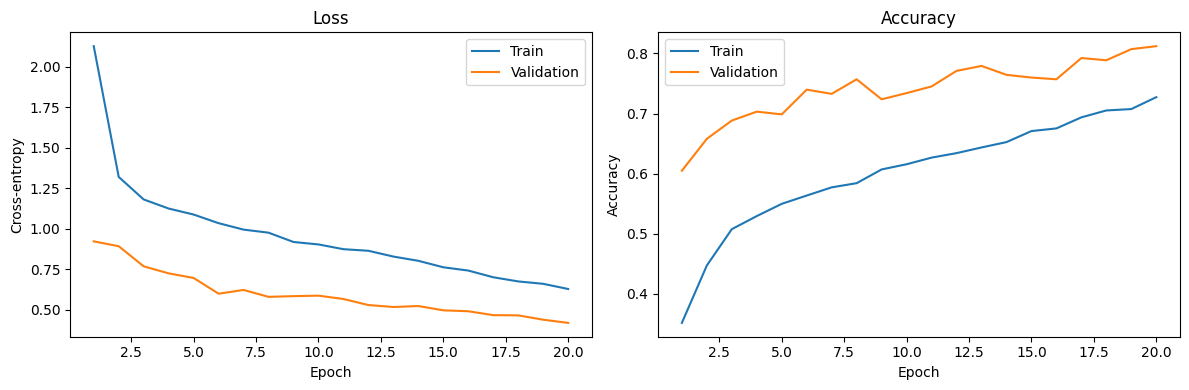

In [ ]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train")
plt.plot(epochs_range, history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train")
plt.plot(epochs_range, history["val_acc"], label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 11. Evaluate on the Test Set
Reports final performance using the held-out split.


In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="Test")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.3f}")


Test:   0%|          | 0/117 [00:00<?, ?batch/s]

Test loss: 0.3799
Test accuracy: 0.845


## 12. (Optional) Save the Trained Model
Toggle this to persist the model weights for reuse or submission.


In [ ]:
SAVE_MODEL = True  # Switch to True to persist the trained weights

if SAVE_MODEL:
    checkpoint_dir = Path("checkpoints")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = checkpoint_dir / "baseline_cnn.pt"
    torch.save({
        "model_state_dict": model.state_dict(),
        "class_names": class_names,
        "image_size": IMAGE_SIZE,
    }, checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path.resolve()}")

Saved checkpoint to /content/checkpoints/baseline_cnn.pt
